> Code to accompany **Chapter 5: The Principles of Adversarial Input**

# Testing Random Images - Fashion-MNIST


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
model = tf.keras.models.load_model('../models/fashion-MNIST.h5')

Instructions for updating:
Colocations handled automatically by placer.


## Create a random image and get its predictions

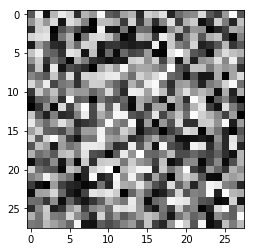

In [2]:
r = np.random.RandomState(2)
image = r.randint(256, size=(28,28))
plt.imshow(image, cmap=plt.cm.binary)

## Get its predictions

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

predictions = model.predict(np.expand_dims(image, axis=0))[0]
print(predictions)
print("Classification: ", class_names[np.argmax(predictions)])
print("Confidence:     ", predictions[np.argmax(predictions)])



[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Classification:  Bag
Confidence:      1.0


## Retrain the model with 'unknown' label

Our current Fashion-MNIST model assumes the data is always sensible. Let's retrain the model with an extra class to capture random (out of distribution) data.

## Create random training and test data

There are 60,000 training images - 6,000 per existing label. So we'll create an extra 6,000 random ones.

There are 10,000 test images - 1,000 per existing label. So we'll create and extra 1,000 random ones.

In [4]:
import numpy as np

num_train = 6000
num_test = 1000

fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images/255.0
test_images = test_images/255.00

extended_train_images = np.concatenate((train_images, np.random.rand(num_train,28,28)), axis=0)
extended_train_labels = np.append(train_labels, np.full((num_train), 10))

extended_test_images = np.concatenate((test_images, np.random.rand(num_test,28,28)), axis=0)
extended_test_labels = np.append(test_labels, np.full((num_test), 10))


## Redefine the model to cater for the extra label

In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot', 'Unknown']

model = keras.Sequential([keras.layers.Flatten(input_shape=(28,28)),
                          keras.layers.Dense(56, activation='relu'),
                          keras.layers.Dense(56, activation='relu'),
                          keras.layers.Dense(11, activation='softmax', name='predictions_layer')
                         ])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Note the extra dimension in the predictions_layer.

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 56)                43960     
_________________________________________________________________
dense_1 (Dense)              (None, 56)                3192      
_________________________________________________________________
predictions_layer (Dense)    (None, 11)                627       
Total params: 47,779
Trainable params: 47,779
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [7]:
model.fit(extended_train_images, extended_train_labels, epochs=6)

Epoch 1/6
66000/66000 [==============================] - 7s 109us/sample - loss: 0.4711 - acc: 0.8340
Epoch 2/6
66000/66000 [==============================] - 8s 126us/sample - loss: 0.3454 - acc: 0.8744
Epoch 3/6
66000/66000 [==============================] - 8s 125us/sample - loss: 0.3128 - acc: 0.8853
Epoch 4/6
66000/66000 [==============================] - 7s 108us/sample - loss: 0.2934 - acc: 0.8922
Epoch 5/6
66000/66000 [==============================] - 7s 109us/sample - loss: 0.2770 - acc: 0.8972
Epoch 6/6
66000/66000 [==============================] - 5s 70us/sample - loss: 0.2650 - acc: 0.9005


## Check its accuracy and show the confusion matrix

In [8]:
test_loss, test_acc = model.evaluate(extended_test_images, extended_test_labels)
print('Model accuracy based on test data:', test_acc)

11000/11000 [==============================] - 0s 41us/sample - loss: 0.3299 - acc: 0.8805
Model accuracy based on test data: 0.88054544


Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


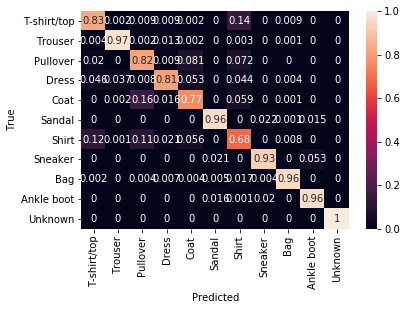

In [9]:
import seaborn as sns

def show_confusion_matrix(model, test_images, expected_labels, class_names):
    predictions = model.predict(test_images)
    num_predictions = predictions.shape[0]
    pred_labels = np.zeros((num_predictions), dtype=int)
    for pred, index in zip(predictions, range(num_predictions)):
        pred_labels[index] = np.argmax(pred)
        
    # Create a confusion matrix on training data.
    with tf.Graph().as_default():
        cm = tf.confusion_matrix(labels=expected_labels, predictions=pred_labels, num_classes=len(class_names))
        with tf.Session() as session:
            cm_out = session.run(cm)

    # Normalize the confusion matrix so that each row sums to 1.
    cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_out, annot=True, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    
show_confusion_matrix(model, extended_test_images, extended_test_labels, class_names)